Water vapor plays a significant role in atmospheric absorption, which in turn affects astronomical observations.

Precipitable water vapor is the total amount of atmospheric water vapor in a vertical column of air, measured as the height it would have if it were condensed. An acceptable statistical model for the generation of temporal sequences of PWV values can be useful when modelling absorption effects.

The purpose of this notebook is to produce a stochastic process for the generation of synthetic PWV sequences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gzip
import dateutil
import random
from scipy import stats
import csv

Make sure to set the following configurations correctly.

In [2]:
DATA_DIR = Path("../data")

The following code code reads real PWV measurements for 2023, made using Low Humidity And Temperature Profiling microwave radiometers at the Paranal Observatory, which have been retrieved trough the [LHATPRO Query Form](https://archive.eso.org/wdb/wdb/asm/lhatpro_paranal/form).

The graph shows the available PWV data. It can be seen that occasional negative values are present. These have no physical meaning and are a result of errors. No discernible pattern is immediately apparent.

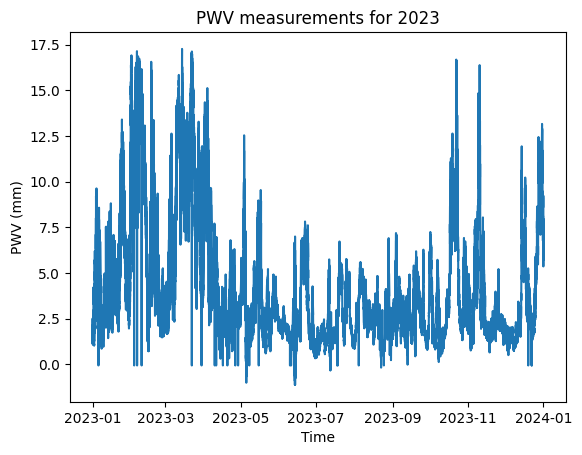

In [18]:
timestamps = []
pwv_values = []

with gzip.open(DATA_DIR / "wdb_query_eso.csv.gz", mode="rt", newline="") as fp:
	reader = csv.reader(fp)
	next(reader)
	next(reader)
	for row in reader:
		if len(row) == 3:
			p, t, pwv = row
			if pwv:
				t = dateutil.parser.parse(t)
				pwv = float(pwv)
				timestamps.append(t)
				pwv_values.append(pwv)

pwv_values = np.asarray(pwv_values)

plt.plot(timestamps, pwv_values)
plt.title("PWV measurements for 2023")
plt.xlabel("Time")
plt.ylabel("PWV ($mm$)")
plt.show()

The available PWV values follow a roughly log-normal distribution, a result consistent with previous [findings](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JD006731). An initial guess for the parameters is computed from the mean and standard deviation of the data. Then, a log-normal distribution is fitted to the data, yielding maximum likelihood estimates of the parameters, which will be used later.

The graph below shows the real distribution of the data and compares it with the computed log-normal model.

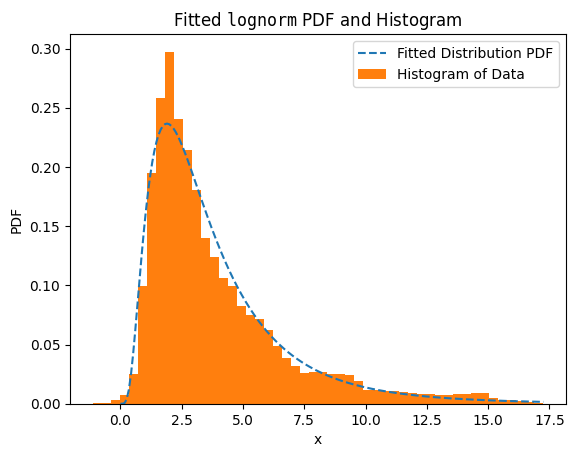

FitParams(s=0.6959828667870336, loc=0.0, scale=3.0861953245011002)


In [4]:
mean = pwv_values.mean()
std = pwv_values.std(ddof=1)
s2 = np.log((std / mean) ** 2 + 1)
s_g = np.sqrt(s2)
scale_g = mean * np.exp(-s2 / 2)

bounds = { "s": (0, 1), "scale": (0, 10) }
guess = { "s": s_g, "scale": scale_g }
result = stats.fit(stats.lognorm, pwv_values, bounds=bounds, guess=guess)
params = result.params
distribution = stats.lognorm(*params)

result.plot()
plt.show()

print(params)

The following code generates a Markovian process of variables $V_i$ such that $V_{k+1}=p \cdot V_k+R_{k+1}$, where $R_i$ variables are independent with distribution $\mathcal{N}(0,1)$ and $0 \le p<1$.

When $k$ is large, $\mathrm{Var}(V_k)$ converges to $\frac{1}{1-p^2}$, due to the properties of geometric series. If $V_0$ has this same variance too and is a normally-distributed random variable independent of $R_i$ variables, then $\mathrm{Var}(V_k)$ is constant and the sampling can start at any point.

A fact which may not be immediately obvious is that any long segment of the generated sequence can be expected to have the same mean and variance as that of any $V_k$. This is a consequence of the fact that any two elements which are sufficiently far away in the sequence are nearly independent.

Multiplying every element $V_i$ of the sequence by $\sqrt{1-p^2}$ results in a new sequence of variables $S_i$ with a variance and standard deviation of 1.

The code below generates and displays in a graph a random sequence as described, then shows the corresponding histogram, overlaid with the standard normal distribution for comparison.

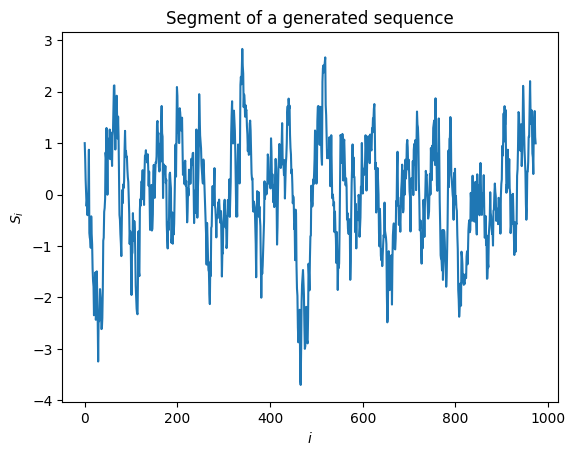

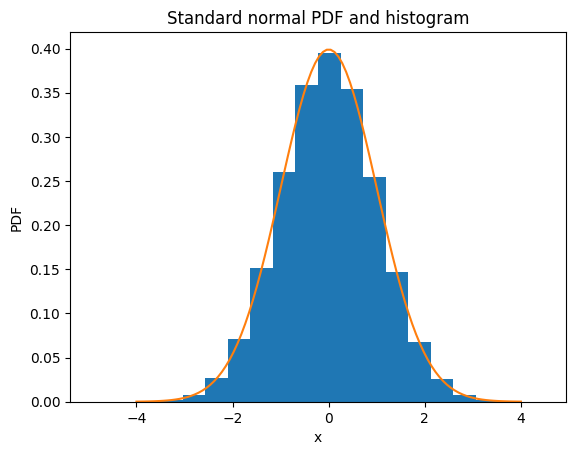

In [37]:
def gen_process(size, p):
	random = np.random.normal(size=size)
	v = random[0] / np.sqrt(1 - p ** 2)
	sequence = np.empty(size)
	sequence[0] = v
	for i in range(1, size):
		v = v * p + random[i]
		sequence[i] = v
	sequence *= np.sqrt(1 - p ** 2)
	return sequence

s = gen_process(1000000, 0.9)

plt.plot(s[:974])
plt.title("Segment of a generated sequence")
plt.xlabel("$i$")
plt.ylabel("$S_i$")
plt.show()

plt.hist(s, bins=20, density=True)
#plt.show()

x = np.linspace(-4, 4, 100)
plt.title("Standard normal PDF and histogram")
plt.xlabel("x")
plt.ylabel("PDF")
plt.plot(x, stats.norm.pdf(x))
plt.show()

The expected value of the difference between any two elements of a sequence generated as above is 0. However, its variance depends on their distance along the sequence.

$\mathrm{Var}(S_n - S_m)$ is 0 when $d=n-m=0$ (since they are really the same element) and then it grows monotonically with $d$. When $n \gg m$, $S_m$ and $S_n$ are nearly independent, so $S_n + (-S_m)$ is effectively the sum of two independent normally distributed random variables and its variance approaches 2, drawing a horizontal asymptote.

From the graph below it can be seen that the value of $p$ can be used to control the rate at which the standard deviation of the difference between two elements in the sequence grows with their distance: as expected, the lower $p$ is, the faster generated values vary across the sequence.

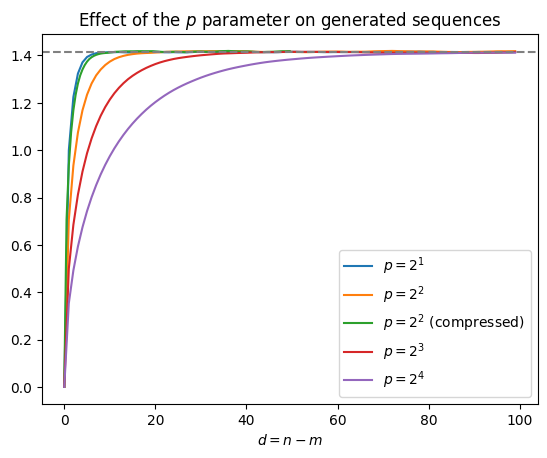

: 

In [39]:
for exp in range(1, 5):
	sequence = gen_process(1000000, 1 - 0.5 ** exp)
	stds = [0]
	for i in range(1, 100):
		diffs = sequence[i:] - sequence[:-i]
		std = np.sqrt(np.sum(diffs ** 2) / diffs.size)
		stds.append(std)
	stds = np.asarray(stds)
	plt.plot(stds, label=f"$p=2^{exp}$")
	#plt.show()
	if exp == 2:
		plt.plot(np.arange(stds.size / 2, step=0.5), stds, label=f"$p=2^{exp}$ (compressed)")
		#plt.show()

plt.axhline(y=np.sqrt(2), linestyle="--", color="gray")

plt.title("Effect of the $p$ parameter on generated sequences")
plt.xlabel("$d=n-m$")
plt.legend()
plt.show()

Random processes of the kind described above can be adapted to yield another (non-normal) distribution, by leveraging the cumulative distribution function of both, using inverse transform sampling. Specifically, taking the exponential of each sample is what needs to be done when targeting a log-normal distribution.

The following code generates a synthetic PVW sequence. The generated values will follow a log-normal distribution. The parameters of the distribution and the pace of variation must be set to physically reasonable values.

The graph below shows a histogram of the generated data, overlined with the corresponding log-normal distribution as per the parameters used for generation and one fitted to the sequence.

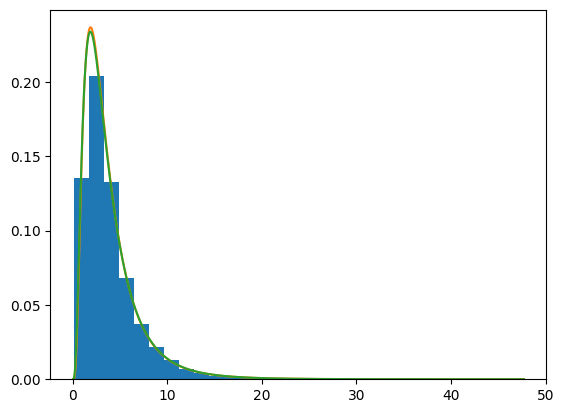

In [7]:
def gen_pwv(size, dt=1, pace=6e5, s=0.69598, scale=3.0862):
	pace /= dt
	p = pace / (pace + 1)
	sequence = gen_process(size, p)
	sequence *= s
	pwv = np.exp(sequence)
	pwv *= scale
	return pwv

pwv = gen_pwv(1000000, pace=1e3)

plt.hist(pwv, bins=30, density=True)
#plt.show()

distribution = stats.lognorm(0.69598, scale=3.0862)
span = np.arange(pwv.max(), step=pwv.max() / 1000) + pwv.max() / 1000
plt.plot(span, distribution.pdf(span))
#plt.show()

params = stats.lognorm.fit(pwv)
distribution = stats.lognorm(*params)
span = np.arange(pwv.max(), step=pwv.max() / 1000) + pwv.max() / 1000
plt.plot(span, distribution.pdf(span))
plt.show()

The following code and graph show the effect of the `pace` parameter on how fast values vary throughout the generated sequence. It can be seen that higher values of the parameter correspond to slower variations.

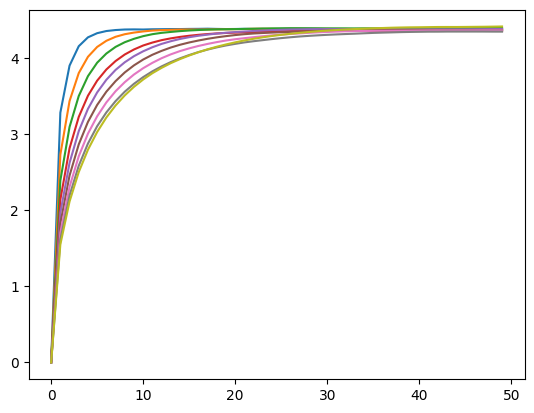

In [8]:
for pace in range(1, 10):
	pwv = gen_pwv(1000000, pace=pace)
	stds = [0]
	for i in range(1, 50):
		diffs = pwv[i:] - pwv[:-i]
		std = np.sqrt(np.sum(diffs ** 2) / diffs.size)
		stds.append(std)
	stds = np.asarray(stds)
	plt.plot(stds)
	#plt.show()

plt.show()

The following code extracts more or less contiguous intervals from available real PWV measurements, which will be used later.

In [9]:
instants = [(t - timestamps[0]).total_seconds() for t in timestamps]
instants = np.asarray(instants)

deltas = instants[1:] - instants[:-1]

cond = deltas > 500
indices = np.empty(pwv_values.size, dtype=np.int32)

count = 0

indices[0] = 0

for i in range(cond.size):
	count += cond[i]
	indices[i + 1] = count

n_intervals = indices[-1]

intervals = []

for i in range(1, n_intervals):
	selected = indices == i
	if selected.sum() >= 100:
		interval_x = instants[selected]
		interval_y = pwv_values[selected]
		intervals.append((interval_x, interval_y))

The following code selects those contiguous intervals in PWV data whose duration falls within a certain range.

The graph displays 10 random sub-sequences among the selected ones. It can be seen that lines are rather jagged. This is likely due, at least in part, to measurement errors, including calibration differences among the three platform.

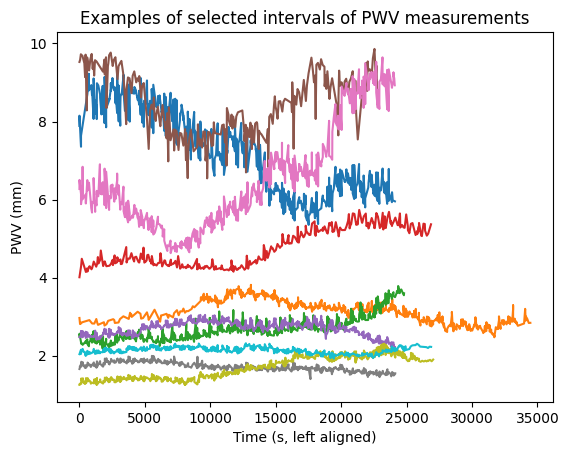

In [23]:
selected_intervals = [(i_x, i_y) for i_x, i_y in intervals if 20000 < i_x[-1] - i_x[0] < 40000]

samples = random.sample(selected_intervals, 10)

for i_x, i_y in samples:
	plt.plot(i_x - i_x[0], i_y)
	#plt.show()

plt.title("Examples of selected intervals of PWV measurements")
plt.xlabel("Time (s, left aligned)")
plt.ylabel("PWV (mm)")
plt.show()

The following code justifies the value $6 \times 10^5$ for the `pace` parameter. It can be seen that, using this value for generation, a real PWV interval, among the previously selected ones, has a standard deviation lower than that of a generated sequence of the same length about half of the times and a higher one the other half.

In [11]:
counts = [0, 0]

for i in range(100):
	pwv1 = gen_pwv(40000, pace=6e5, s=0.66741, scale=3.130097)

	for i_x, i_y in selected_intervals:
		size = int(i_x[-1] - i_x[0])
		std1 = pwv1[:size].std(ddof=1)
		std_real = i_y.std(ddof=1)
		if std_real < std1:
			counts[0] += 1
		else:
			counts[1] += 1

print(counts)

[5828, 6072]


The following code exemplifies the generation of PWV sequences with a duration of 5 hours represented trough 59 samples.

From the graph below it can be seen that sequences with higher values also generally display more variation. The same pattern can be seen in real sequences shown previously.

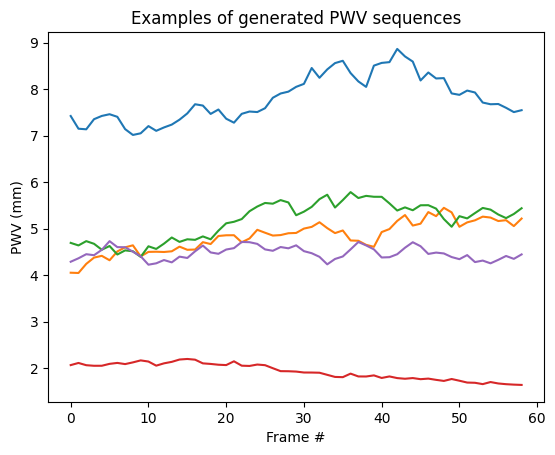

In [20]:
timespan = 5 * 60 * 60
size = 59

for i in range(5):
	pwv = gen_pwv(size, dt=timespan / size, pace=6e5)
	plt.plot(pwv)
	#plt.show()

plt.title("Examples of generated PWV sequences")
plt.xlabel("Frame #")
plt.ylabel("PWV (mm)")
plt.show()